# 개인 프로젝트 예시


## OPEN API를 활용한 네이버 뉴스 텍스트 분석
- 1. 네이버 오픈 API로 기사 URL 크롤링
- 2. bs4 + selenium으로 기사 제목 및 내용 크롤링

In [10]:
import os
import sys
import urllib.request
import requests

news_data = []
page_count = 10

client_id = "frBMA0JHYp1zATqntdUJ"
client_secret = "CzMu_Uce6r"

encText = urllib.parse.quote("백신")

for idx in range(page_count):
    # json 결과
    url = "https://openapi.naver.com/v1/search/news?query=" + encText + "&start=" + str(idx * 10 + 1)
    # url = "https://openapi.naver.com/v1/search/blog.xml?query=" + encText # xml 결과
    request = urllib.request.Request(url)
    request.add_header("X-Naver-Client-Id",client_id)
    request.add_header("X-Naver-Client-Secret",client_secret)
    response = urllib.request.urlopen(request)
    rescode = response.getcode()

    if(rescode==200):
    #    response_body = response.read()
        result = requests.get(response.geturl(),
                              headers={"X-Naver-Client-Id":client_id,
                                       "X-Naver-Client-Secret":client_secret}
                             )
        news_data.append(result.json())
    #    print(response_body.decode('utf-8'))
    else:
        print("Error Code:" + rescode)

### 크롤링한 데이타 살펴보기

- 온라인 json 뷰어 이용하기 : http://jsonviewer.stack.hu/

In [11]:
# print(news_data)
# print(len(news_data))
# print(news_data[0])
# print(news_data[0]['items'])
# print(len(news_data[0]['items']))
# print(news_data[0]['items'][2])
print(news_data[0]['items'][7]['link'])

http://www.healthinnews.co.kr/news/articleView.html?idxno=22208


### 네이버 뉴스 하이퍼링크만 리스트로 저장하기

In [13]:
naver_news_link = []

for page in news_data:
    #print(page)
    page_news_link = []
    
    for item in page['items']:
        # print(item)
        temp_link = item['originallink']
        #print(temp_link)
        if "yna" in temp_link:
            page_news_link.append(temp_link)
    
    naver_news_link.append(page_news_link)
        

# 사이트 링크만 가져오기
for page in naver_news_link:
    for link in page:
        print(link)

http://yna.kr/AKR20210310114200054?did=1195m
http://yna.kr/PYH20210310143800013?did=1196m
http://yna.kr/PYH20210310143800013?did=1196m
http://yna.kr/PYH20210310144100013?did=1196m


### 라이브러리 불러오기

In [6]:
import pandas as pd
import numpy as np
from selenium import webdriver
from tqdm import tqdm_notebook
import requests
import pickle
import re
import ast

from bs4 import BeautifulSoup 
from urllib.request import urlopen
import urllib
import time

### 셀레니움을 사용하기 위해 가상 크롬드라이버 다운로드
- 크롬 드라이브 다운로드 : https://chromedriver.chromium.org/downloads

In [7]:
from selenium import webdriver

driver = webdriver.Chrome('./driver/chromedriver.exe')

### 수집한 네이버 뉴스 사이트를 방문하여 뉴스 타이틀과 본문내용 가져오기

In [15]:
naver_news_link = [v for v in naver_news_link if v]
print (naver_news_link)

[['http://yna.kr/AKR20210310114200054?did=1195m'], ['http://yna.kr/PYH20210310143800013?did=1196m'], ['http://yna.kr/PYH20210310143800013?did=1196m', 'http://yna.kr/PYH20210310144100013?did=1196m']]


In [16]:
naver_news_title = []
naver_news_content = []


for n in tqdm_notebook(range(len(naver_news_link))):
    #print(n)
    news_page_title = []
    news_page_content = []
    
    for idx in tqdm_notebook(range(len(naver_news_link[n]))):        
        
    ########### 긁어온 URL로 접속하기 ############    
        try:
            driver.get(naver_news_link[n][idx])
            print(naver_news_link[n][idx])
            
        except:
            print("Timeout!")
            continue        
        
        try:
            response = driver.page_source
            
        except UnexpectedAlertPresentException:
            driver.switch_to_alert().accept()
            print("게시글이 삭제된 경우입니다.")
            continue
        
        soup = BeautifulSoup(response, "html.parser")
        
        ###### 뉴스 타이틀 긁어오기 ######        
        title = None
        
        try:
            item = soup.find('div', class_="article_info")
            title = item.find('h3', class_="tts_head").get_text()
            #print(title)

        except:
            title = "OUTLINK"
        
        #print(title)
        news_page_title.append(title)
        
        
        ###### 뉴스 본문 긁어오기 ######        
        doc = None
        text = ""
                
        data = soup.find_all("div", {"class" : "_article_body_contents"})
        if data:
            for item in data:

                text = text + str(item.find_all(text=True)).strip()
                text = ast.literal_eval(text)
                doc = ' '.join(text)
   
        else:
            doc = "OUTLINK"
            
        news_page_content.append(doc.replace('\n', ' '))

                
    naver_news_title.append(news_page_title)
    naver_news_content.append(news_page_content)

    time.sleep(2)
    
    
print(naver_news_title[0])
print("==================================")
print(naver_news_content[0])

<ipython-input-16-1b13de154505>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for n in tqdm_notebook(range(len(naver_news_link))):


<ipython-input-16-1b13de154505>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for idx in tqdm_notebook(range(len(naver_news_link[n]))):


http://yna.kr/AKR20210310114200054?did=1195m



http://yna.kr/PYH20210310143800013?did=1196m



http://yna.kr/PYH20210310143800013?did=1196m
http://yna.kr/PYH20210310144100013?did=1196m


['OUTLINK']
['OUTLINK']


In [18]:
print(naver_news_title[1])

['OUTLINK']


In [19]:
print(naver_news_content[0])

['   본문 내용     TV플레이어     // TV플레이어     // flash 오류를 우회하기 위한 함수 추가 function _flash_removeCallback() {}    교도통신, 복수 일본 정부 관계자 인용 보도 “日 거주자만 관람…관객 상한은 4월 결정” 최종 결정시 해외 판매 티켓 환불 진행해야 日, 신규 확진 다시  1000 명대 재점화 도쿄올림픽 ‘일단 멈춤’  - 지난  23 일 도쿄 시내에 내걸린 오륜기가 진입금지 표지판 뒤에 가려진 모습이 코로나 19  사태로 올해 열리지 못한 도쿄올림픽의 운명을 보여 주는 듯하다. 도쿄 로이터 연합뉴스 IOC  집행위 참석 후 기자회견하는 신임 도쿄올림픽 조직위장 - 하시모토 세이코 신임 도쿄올림픽조직위원회 회장이  24 일(현지시간) 도쿄에서 화상으로  IOC  집행위원회 회의에 참석한 뒤 기자회견을 하고 있다. 하시모토 회장은 이날 집행위원회에 처음으로 업무 진행 상황을 전달했다. 로이터 도쿄 연합뉴스  2021-02-25 일본 내 코로나 19 (신종 코로나바이러스 감염증) 확진자가 다시  1000 명대로 치솟은 가운데 일본 정부가 오는 7월 열리는 도쿄올림픽·패럴림픽 때 해외 일반 관객을 수용하지 않기로 방침을 굳혔다고 교도통신이 복수의 정부 관계자를 인용해 9일 보도했다. 통신에 따르면 다음 주에도 일본 정부와 대회 조직위원회, 도쿄도, 국제올림픽위원회( IOC ), 국제패럴림픽위원회( IPC ) 등의 대표가 참가하는 5자 회의에서 이러한 결정을 재확인할 것으로 전해졌다.  MobileAdNew center  도쿄올림픽·패럴림픽 관객은 일본 내 거주자로 한정하고, 관객 상한은 일본 정부의 코로나 19  대책에 따른 행사 제한 방침에 근거해 4월에 결정한다고 교도통신은 전했다. 4개월 뒤 개최 예정인 도쿄올림픽 해외 관객을 받지 않기로 최종 결정되면 조직위는 해외에서 판매된 올림픽 티켓의 환불 절차를 진행해야 한다. IOC  집행위 화상회의 참석한 바흐 위원장 - 토마스 바흐 국제올림픽

In [20]:
print(len(naver_news_title[0]))
print(len(naver_news_content[0]))

7
7


### 피클형태로 저장

In [30]:
with open("./data/naver_news_title.pk", "wb") as f:
    pickle.dump(naver_news_title, f)
    
with open("./data/naver_news_content.pk", "wb") as f:
    pickle.dump(naver_news_content, f)

-------------------------------
## 형태소 분석기 제작하기
- 1. 사용할 형태소 분석기 불러오기
- 2. 텍스트 전처리 하기
- 3. 형태소 / POS tagging 하기

### 형태소 불러오기

In [23]:
from konlpy.tag import Okt
import re

okt = Okt()

# 경고 알림이 뜨면 모두 무시
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

### 텍스트 전처리

In [24]:
def text_cleaning(doc):
    # 한국어를 제외한 글자를 제거하는 함수.
    doc = re.sub("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "", doc)
    return doc

def define_stopwords(path):    
    SW = set()
    # 불용어를 추가하는 방법 1)
    # SW.add("있다")
    
    # 불용어를 추가하는 방법 2)
    # stopwords-ko.txt에 직접 추가
    
    with open(path) as f:
        for word in f:
            SW.add(word)            
    return SW

def text_tokenizing(doc):    
    # list comprehension을 풀어서 쓴 코드.1)     
#     tokenized_doc = []
    
#     for word in okt.morphs(doc):
#         if word not in SW and len(word) > 1:
#             tokenized_doc.append(word)
    
#     return tokenized_doc    
    return [word for word in okt.morphs(doc) if word not in SW and len(word) > 1]

In [25]:
text = """5G 이동통신망을 빌려 사용하는 ‘5G 알뜰폰’이 올해 도입되고, 내년부터는 의무화된다.
정부는 알뜰폰 사업자(MNVO)가 통신사(MNO)에 통신망을 빌리는 비용(도매대가)을 지난해보다 큰 폭으로 낮춰, 알뜰폰 요금 인하를 유도하기로 했다. 하지만 줄어드는 알뜰폰 시장을 살릴 수 있을지는 지켜봐야 하는 상황이다.
과학기술정보통신부는 알뜰폰 활성화 추진대책을 25일 발표했다. 알뜰폰 가입자는 800만명으로 이동통신 시장의 12%를 차지한다. 2011년 출시 뒤 저렴한 요금제로 통신비 부담을 낮춰왔다. 하지만 지난해 5월 통신 3사가 준보편제 요금을 내놓은 이후 알뜰폰 이탈 현상이 지속되고 있다.
우선 올해 안에 3개 이상의 5G 알뜰폰이 시장에 나온다. 통신사가 5G망을 알뜰폰 사업자에게 도매 제공할지 여부는 통신사 자율로 정한다. 앞서 LG유플러스는 오는 10월 알뜰폰 사업을 시작하는 KB국민은행에 5G망을 제공한다고 밝힌 바 있다. SK텔레콤와 KT도 특정 제휴사를 선택해 올해 안에 5G 알뜰폰을 내놓기로 했다.
내년부터는 5G 알뜰폰 제공이 의무화된다. 지난 22일자로 종료된 도매제공 의무제도의 유효기간을 2022년 9월22일까지 연장하는 전기통신사업법 개정안이 국회에서 통과되면, 관련 고시를 개정해 SK텔레콤의 5G망 도매제공을 의무화하겠다는 것이다.
과기정통부 관계자는 “SK텔레콤이 자사와 계약을 맺은 13개 알뜰폰 사업자에게 5G망을 의무 제공하면, 그 외 31개의 알뜰폰 사업자들이 경쟁에서 밀릴 것을 우려해 KT와 LG유플러스도 5G망을 제공하게 될 것”이라고 내다봤다.
알뜰폰 사업자가 상품을 만드는 방식 크게 2가지다. 하나는 통신사로부터 음성·문자·데이터를 도매로 사들인 뒤 이를 바탕으로 통신사보다 저렴한 요금제를 내놓는 방식(종량제 도매제공)이다. 이를 위해 정부는 도매대가 인하율을 음성 17.8%, 데이터 19.2%, 단문메시지 1.15%로, 지난해 음성 15.1%, 데이터 19.1%, 단문메시지 1.13%에 비해 높여 잡았다.
또 다른 방식은 일정비용을 통신사에 내고 통신사의 정액 요금제를 그대로 판매하면서, 그 차액의 범위에서 저렴한 요금제를 내놓는 방식(수익배분 도매제공)이다. 정부는 SK텔레콤의 준보편 요금제인 ‘T플랜 요금제’를 알뜰폰 사업자가 재판매할 수 있게 했다. 기존에 SK텔레콤이 도매제공했던 ‘밴드데이터 요금제’의 최고구간의 대가도 1.5%포인트 낮췄다.
알뜰폰 업계는 대체로 반기는 분위기지만, 알뜰폰 시장을 살릴 수 있을지에는 의구심을 갖고 있다. 업계 관계자는 “도매대가 인하율이 크고, 5G망을 제공하는 것은 긍정적”이라면서도 “수익배분 도매제공의 의무화, 설비를 가진 업체에 대한 접속료 정산 도입 등의 제도적 개선이 필요하다”고 말했다."""

In [28]:
SW = define_stopwords("./data/stopwords-ko.txt")

cleaned_text = text_cleaning(text)
print("전처리 결과 : ", cleaned_text)

tokenized_text = text_tokenizing(cleaned_text)
print("\n형태소 분석 결과 : ", tokenized_text)

전처리 결과 :   이동통신망을 빌려 사용하는  알뜰폰이 올해 도입되고 내년부터는 의무화된다정부는 알뜰폰 사업자가 통신사에 통신망을 빌리는 비용도매대가을 지난해보다 큰 폭으로 낮춰 알뜰폰 요금 인하를 유도하기로 했다 하지만 줄어드는 알뜰폰 시장을 살릴 수 있을지는 지켜봐야 하는 상황이다과학기술정보통신부는 알뜰폰 활성화 추진대책을 일 발표했다 알뜰폰 가입자는 만명으로 이동통신 시장의 를 차지한다 년 출시 뒤 저렴한 요금제로 통신비 부담을 낮춰왔다 하지만 지난해 월 통신 사가 준보편제 요금을 내놓은 이후 알뜰폰 이탈 현상이 지속되고 있다우선 올해 안에 개 이상의  알뜰폰이 시장에 나온다 통신사가 망을 알뜰폰 사업자에게 도매 제공할지 여부는 통신사 자율로 정한다 앞서 유플러스는 오는 월 알뜰폰 사업을 시작하는 국민은행에 망을 제공한다고 밝힌 바 있다 텔레콤와 도 특정 제휴사를 선택해 올해 안에  알뜰폰을 내놓기로 했다내년부터는  알뜰폰 제공이 의무화된다 지난 일자로 종료된 도매제공 의무제도의 유효기간을 년 월일까지 연장하는 전기통신사업법 개정안이 국회에서 통과되면 관련 고시를 개정해 텔레콤의 망 도매제공을 의무화하겠다는 것이다과기정통부 관계자는 텔레콤이 자사와 계약을 맺은 개 알뜰폰 사업자에게 망을 의무 제공하면 그 외 개의 알뜰폰 사업자들이 경쟁에서 밀릴 것을 우려해 와 유플러스도 망을 제공하게 될 것이라고 내다봤다알뜰폰 사업자가 상품을 만드는 방식 크게 가지다 하나는 통신사로부터 음성문자데이터를 도매로 사들인 뒤 이를 바탕으로 통신사보다 저렴한 요금제를 내놓는 방식종량제 도매제공이다 이를 위해 정부는 도매대가 인하율을 음성  데이터  단문메시지 로 지난해 음성  데이터  단문메시지 에 비해 높여 잡았다또 다른 방식은 일정비용을 통신사에 내고 통신사의 정액 요금제를 그대로 판매하면서 그 차액의 범위에서 저렴한 요금제를 내놓는 방식수익배분 도매제공이다 정부는 텔레콤의 준보편 요금제인 플랜 요금제를 알뜰폰 사업자가 재판매할 수 있게 했다 기존에 텔레콤이 도매제공했던 

----------------------------
## 피클형태 데이타 읽어와서 빈도 챠트와 워드 클라우드 그리기

### 데이타 전처리와 데이타 불러오기 함수

In [31]:
from tqdm import tqdm_notebook # progress bar
from konlpy.tag import Okt #Okt 등 형태소 분석기 불러오기
import numpy as np
import string # 특수문자
import re
import warnings # 경고 알림 제거
import pickle
from gensim import corpora
from gensim import models
import matplotlib.pyplot as plt
%matplotlib inline

warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [61]:
def read_documents(input_file_name):
    """문서들을 주어진 이름의 파일로부터 읽어들여 돌려준다."""
    
    corpus = []
    
    with open(input_file_name, 'rb') as f:
        temp_corpus = pickle.load(f)
        
    for page in temp_corpus:
        corpus += page
    
    return corpus

def text_cleaning(doc):
    # 한국어를 제외한 글자를 제거하는 함수.
    doc = re.sub("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "", str(doc))
    return doc

def define_stopwords(path):    
    SW = set()
    # 불용어를 추가하는 방법 1)
    # SW.add("있다")
    
    # 불용어를 추가하는 방법 2)
    # stopwords-ko.txt에 직접 추가
    
    with open(path) as f:
        for word in f:
            SW.add(word)            
    return SW


def text_tokenizing(doc):
    return [word for word in okt.nouns(doc) if word not in SW and len(word) > 1]

In [57]:
input_file_name = "./data/naver_news_content.pk"
documents = read_documents(input_file_name)
documents

['   본문 내용     TV플레이어     // TV플레이어     // flash 오류를 우회하기 위한 함수 추가 function _flash_removeCallback() {}    교도통신, 복수 일본 정부 관계자 인용 보도 “日 거주자만 관람…관객 상한은 4월 결정” 최종 결정시 해외 판매 티켓 환불 진행해야 日, 신규 확진 다시  1000 명대 재점화 도쿄올림픽 ‘일단 멈춤’  - 지난  23 일 도쿄 시내에 내걸린 오륜기가 진입금지 표지판 뒤에 가려진 모습이 코로나 19  사태로 올해 열리지 못한 도쿄올림픽의 운명을 보여 주는 듯하다. 도쿄 로이터 연합뉴스 IOC  집행위 참석 후 기자회견하는 신임 도쿄올림픽 조직위장 - 하시모토 세이코 신임 도쿄올림픽조직위원회 회장이  24 일(현지시간) 도쿄에서 화상으로  IOC  집행위원회 회의에 참석한 뒤 기자회견을 하고 있다. 하시모토 회장은 이날 집행위원회에 처음으로 업무 진행 상황을 전달했다. 로이터 도쿄 연합뉴스  2021-02-25 일본 내 코로나 19 (신종 코로나바이러스 감염증) 확진자가 다시  1000 명대로 치솟은 가운데 일본 정부가 오는 7월 열리는 도쿄올림픽·패럴림픽 때 해외 일반 관객을 수용하지 않기로 방침을 굳혔다고 교도통신이 복수의 정부 관계자를 인용해 9일 보도했다. 통신에 따르면 다음 주에도 일본 정부와 대회 조직위원회, 도쿄도, 국제올림픽위원회( IOC ), 국제패럴림픽위원회( IPC ) 등의 대표가 참가하는 5자 회의에서 이러한 결정을 재확인할 것으로 전해졌다.  MobileAdNew center  도쿄올림픽·패럴림픽 관객은 일본 내 거주자로 한정하고, 관객 상한은 일본 정부의 코로나 19  대책에 따른 행사 제한 방침에 근거해 4월에 결정한다고 교도통신은 전했다. 4개월 뒤 개최 예정인 도쿄올림픽 해외 관객을 받지 않기로 최종 결정되면 조직위는 해외에서 판매된 올림픽 티켓의 환불 절차를 진행해야 한다. IOC  집행위 화상회의 참석한 바흐 위원장 - 토마스 바흐 국제올림픽

In [59]:
SW = define_stopwords("./data/stopwords-ko.txt")
SW 

{'가\n',
 '가까스로\n',
 '가령\n',
 '각\n',
 '각각\n',
 '각자\n',
 '각종\n',
 '갖고말하자면\n',
 '같다\n',
 '같이\n',
 '개의치않고\n',
 '거니와\n',
 '거바\n',
 '거의\n',
 '것\n',
 '것과 같이\n',
 '것들\n',
 '게다가\n',
 '게우다\n',
 '겨우\n',
 '견지에서\n',
 '결과에 이르다\n',
 '결국\n',
 '결론을 낼 수 있다\n',
 '겸사겸사\n',
 '고려하면\n',
 '고로\n',
 '곧\n',
 '공동으로\n',
 '과\n',
 '과연\n',
 '관계가 있다\n',
 '관계없이\n',
 '관련이 있다\n',
 '관하여\n',
 '관한\n',
 '관해서는\n',
 '구\n',
 '구체적으로\n',
 '구토하다\n',
 '그\n',
 '그들\n',
 '그때\n',
 '그래\n',
 '그래도\n',
 '그래서\n',
 '그러나\n',
 '그러니\n',
 '그러니까\n',
 '그러면\n',
 '그러므로\n',
 '그러한즉\n',
 '그런 까닭에\n',
 '그런데\n',
 '그런즉\n',
 '그럼\n',
 '그럼에도 불구하고\n',
 '그렇게 함으로써\n',
 '그렇지\n',
 '그렇지 않다면\n',
 '그렇지 않으면\n',
 '그렇지만\n',
 '그렇지않으면\n',
 '그리고\n',
 '그리하여\n',
 '그만이다\n',
 '그에 따르는\n',
 '그위에\n',
 '그저\n',
 '그중에서\n',
 '그치지 않다\n',
 '근거로\n',
 '근거하여\n',
 '기대여\n',
 '기점으로\n',
 '기준으로\n',
 '기타\n',
 '까닭으로\n',
 '까악\n',
 '까지\n',
 '까지 미치다\n',
 '까지도\n',
 '꽈당\n',
 '끙끙\n',
 '끼익\n',
 '나\n',
 '나머지는\n',
 '남들\n',
 '남짓\n',
 '너\n',
 '너희\n',
 '너희들\n',
 '네\n',
 '넷\n',
 '년\n',
 '논하지 않다\n',
 '놀라다\n',

In [60]:
cleaned_text = text_cleaning(documents)
cleaned_text

'   본문 내용     플레이어      플레이어       오류를 우회하기 위한 함수 추가       교도통신 복수 일본 정부 관계자 인용 보도  거주자만 관람관객 상한은 월 결정 최종 결정시 해외 판매 티켓 환불 진행해야  신규 확진 다시   명대 재점화 도쿄올림픽 일단 멈춤   지난   일 도쿄 시내에 내걸린 오륜기가 진입금지 표지판 뒤에 가려진 모습이 코로나   사태로 올해 열리지 못한 도쿄올림픽의 운명을 보여 주는 듯하다 도쿄 로이터 연합뉴스   집행위 참석 후 기자회견하는 신임 도쿄올림픽 조직위장  하시모토 세이코 신임 도쿄올림픽조직위원회 회장이   일현지시간 도쿄에서 화상으로    집행위원회 회의에 참석한 뒤 기자회견을 하고 있다 하시모토 회장은 이날 집행위원회에 처음으로 업무 진행 상황을 전달했다 로이터 도쿄 연합뉴스   일본 내 코로나  신종 코로나바이러스 감염증 확진자가 다시   명대로 치솟은 가운데 일본 정부가 오는 월 열리는 도쿄올림픽패럴림픽 때 해외 일반 관객을 수용하지 않기로 방침을 굳혔다고 교도통신이 복수의 정부 관계자를 인용해 일 보도했다 통신에 따르면 다음 주에도 일본 정부와 대회 조직위원회 도쿄도 국제올림픽위원회   국제패럴림픽위원회   등의 대표가 참가하는 자 회의에서 이러한 결정을 재확인할 것으로 전해졌다     도쿄올림픽패럴림픽 관객은 일본 내 거주자로 한정하고 관객 상한은 일본 정부의 코로나   대책에 따른 행사 제한 방침에 근거해 월에 결정한다고 교도통신은 전했다 개월 뒤 개최 예정인 도쿄올림픽 해외 관객을 받지 않기로 최종 결정되면 조직위는 해외에서 판매된 올림픽 티켓의 환불 절차를 진행해야 한다   집행위 화상회의 참석한 바흐 위원장  토마스 바흐 국제올림픽위원회   위원장이 일현지시간 스위스 로잔에서 화상으로 열린    집행위원회 회의에 참석하고 있다   는 올해 월 일본에서 열릴 도쿄올림픽 패럴림픽의 해외 관중 수용 여부를 이달 말까지 결정하겠다고 밝혔다    제공 로잔 로이터 연합뉴스       그리스에서 출

In [62]:
tokenized_text = text_tokenizing(cleaned_text)

In [63]:
tokenized_text

['본문',
 '내용',
 '플레이어',
 '플레이어',
 '오류',
 '우회',
 '함수',
 '추가',
 '교도통신',
 '복수',
 '일본',
 '정부',
 '관계자',
 '인용',
 '보도',
 '거주',
 '자만',
 '관람',
 '관객',
 '상한',
 '결정',
 '최종',
 '결정',
 '해외',
 '판매',
 '티켓',
 '환불',
 '진행',
 '신규',
 '확진',
 '다시',
 '명대',
 '점화',
 '도쿄올림픽',
 '일단',
 '지난',
 '도쿄',
 '시내',
 '오륜기',
 '진입',
 '금지',
 '표지판',
 '가려진',
 '모습',
 '코로나',
 '사태',
 '올해',
 '리지',
 '도쿄올림픽',
 '운명',
 '도쿄',
 '로이터',
 '연합뉴스',
 '행위',
 '참석',
 '기자회견',
 '신임',
 '도쿄올림픽',
 '조직',
 '위장',
 '하시모토',
 '세이',
 '신임',
 '도쿄올림픽',
 '조직',
 '위원회',
 '회장',
 '시간',
 '도쿄',
 '화상',
 '집행',
 '위원회',
 '회의',
 '참석',
 '기자회견',
 '하시모토',
 '회장',
 '집행',
 '위원회',
 '처음',
 '업무',
 '진행',
 '상황',
 '전달',
 '로이터',
 '도쿄',
 '연합뉴스',
 '일본',
 '코로나',
 '신종',
 '코로나바이러스',
 '감염증',
 '진자',
 '다시',
 '명대',
 '가운데',
 '일본',
 '정부',
 '도쿄올림픽',
 '패럴림픽',
 '해외',
 '일반',
 '관객',
 '수용',
 '방침',
 '교도통신',
 '복수',
 '정부',
 '관계자',
 '인용',
 '보도',
 '통신',
 '다음',
 '일본',
 '정부',
 '대회',
 '조직',
 '위원회',
 '도쿄도',
 '국제올림픽위원회',
 '국제',
 '패럴림픽',
 '위원회',
 '대표',
 '참가',
 '회의',
 '결정',
 '확인',
 '도쿄올림픽',
 '패럴림픽',
 '관객',
 '일본',
 '거주

### NLTK를 이용한 histogram 분석

In [67]:
import nltk
print(len(tokenized_text))

3070


In [72]:
from pprint import pprint
text = nltk.Text(tokenized_text, name='naver_news')
print(len(set(tokenized_text)))
pprint(text.vocab().most_common(10))

1232
[('코로나', 73),
 ('본문', 34),
 ('내용', 34),
 ('플레이어', 34),
 ('공포', 34),
 ('일본', 28),
 ('무상증자', 25),
 ('결정', 24),
 ('기업', 24),
 ('정부', 22)]


### Histogram 그리기

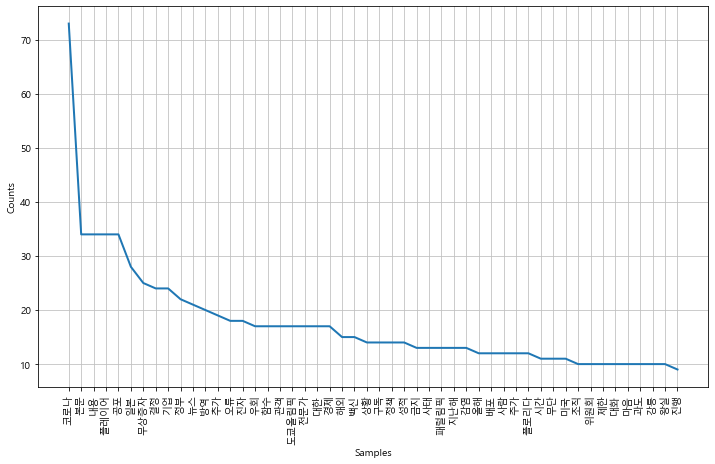

In [74]:
import matplotlib.pyplot as plt
import platform
from matplotlib import font_manager, rc
%matplotlib inline

path = "c:/Windows/Fonts/malgun.ttf"
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system... sorry~~~~')

plt.figure(figsize=(12, 7))
text.plot(50)

### WordCloud 그리기

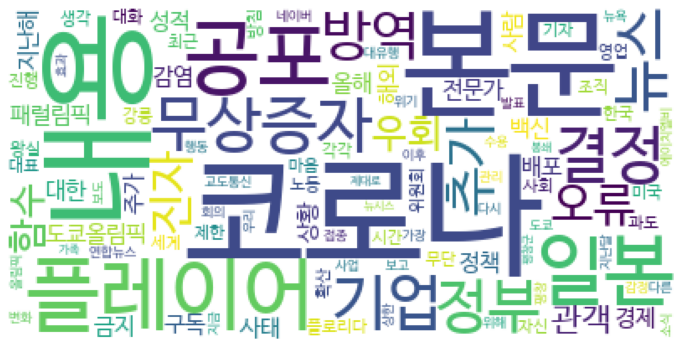

In [83]:
from wordcloud import WordCloud

data = text.vocab().most_common(100)

wordcloud = WordCloud(font_path='/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf',
                      relative_scaling = 0.2,
                      #stopwords=STOPWORDS,
                      background_color='white',
                      ).generate_from_frequencies(dict(data))
plt.figure(figsize=(12,7))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### 원하는 이미지를 이용한 워드 클라우드 그리기

In [79]:
from wordcloud import ImageColorGenerator
import numpy as np
from PIL import Image

mask = np.array(Image.open('heart.jpg'))
image_colors = ImageColorGenerator(mask)

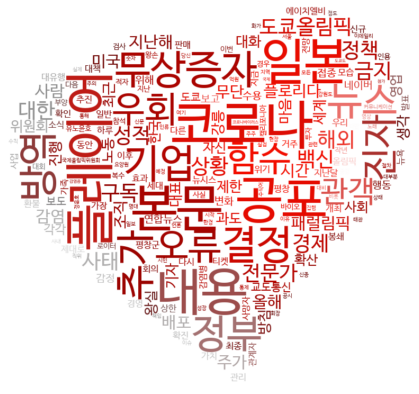

In [81]:
data = text.vocab().most_common(200)

wordcloud = WordCloud(font_path='/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf',
               relative_scaling = 0.1, mask=mask,
               background_color = 'white',
               min_font_size=1,
               max_font_size=100).generate_from_frequencies(dict(data))

default_colors = wordcloud.to_array()

plt.figure(figsize=(10,7))
plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation='bilinear')
plt.axis('off')
plt.show()